In [2]:
import torch
from torch import nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F


In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/demouser/good_python/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).cuda()
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        s_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [5]:
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [6]:
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).cuda()
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).cuda()
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [7]:
data = pd.read_csv("nasdaq100_padding.csv")

In [8]:
data.shape

(40560, 82)

In [9]:
data.head()

AAL   AAPL   ADBE    ADI      ADP       ADSK   AKAM     ALXN    AMAT  \
0  35.9800  96.80  97.80  61.15  95.4000  58.180000  58.00  127.040  26.680   
1  35.9310  96.89  97.80  61.61  95.4115  58.190000  58.12  126.060  26.730   
2  35.9044  96.95  97.57  61.98  95.5100  58.203333  57.95  126.510  26.712   
3  35.8900  96.97  97.55  62.09  95.5200  58.216667  57.96  126.280  26.740   
4  36.0080  96.96  97.73  61.89  95.5300  58.230000  58.21  126.585  26.720   

       AMGN  ...    TXN    VIAB      VOD    VRTX     WBA    WDC    WFM   XLNX  \
0  165.8100  ...  70.73  45.230  31.1701  95.270  81.365  52.16  33.95  48.61   
1  165.9101  ...  70.69  45.010  31.1900  94.170  81.540  52.15  34.10  48.74   
2  166.1800  ...  71.30  45.015  31.2100  94.749  81.530  52.27  34.01  48.99   
3  166.1480  ...  71.31  45.020  31.2100  94.310  81.710  52.30  33.96  48.95   
4  165.9900  ...  71.06  45.050  31.1800  94.155  81.720  52.30  34.17  48.89   

     YHOO       NDX  
0  38.010  4665.054  
1  38.140  4665.054  
2  38.150  4665.826  
3  38.195  4667.081  
4  38.320  4664.491  

[5 rows x 82 columns]

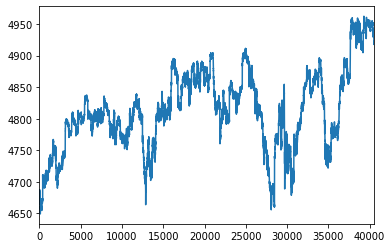

In [10]:
data["NDX"].plot()

In [11]:
batch_size = 128
timesteps = 16
n_timeseries = data.shape[1] - 1
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [12]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))

In [13]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [14]:
for j in range(timesteps):
    y[:, j, 0] = data["NDX"].shift(timesteps - j - 1).fillna(method="bfill")

In [15]:
prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [16]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

In [17]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [18]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [19]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

### DARNN

In [20]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [21]:
model = DARNN(X_train.shape[2], 64, 64, X_train.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [23]:
from torch.utils.data import TensorDataset, DataLoader
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=128)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Saving...
Iter:  0 train:  0.15016105441537428 val:  0.022298338738971284
mse:  34.221413 mae:  4.5876


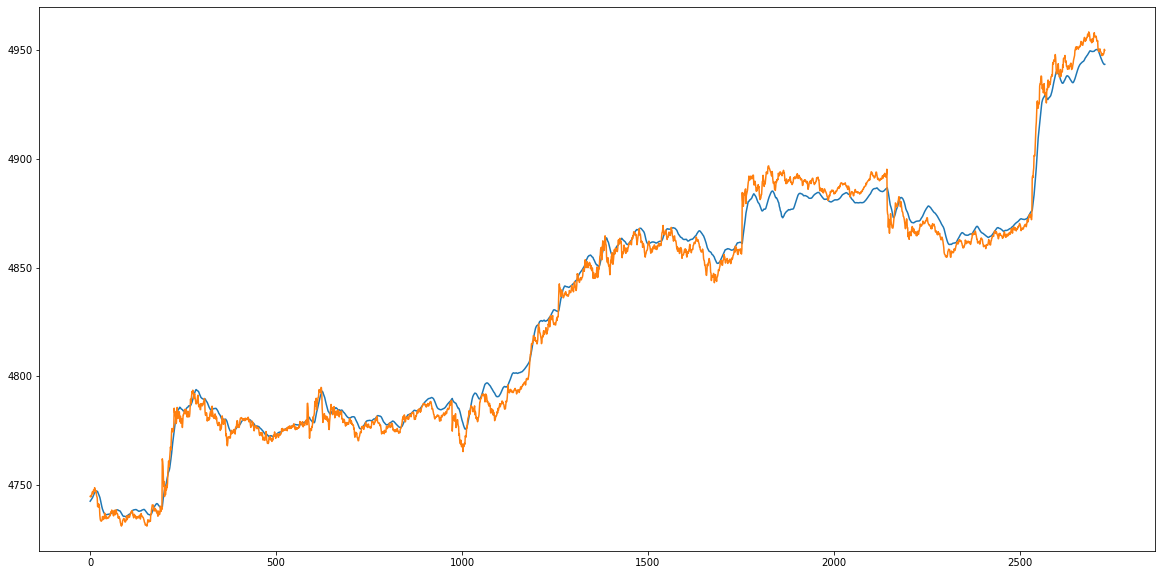

Saving...
Iter:  1 train:  0.017492703946618126 val:  0.016043476903151232
Saving...
Iter:  2 train:  0.015711567061212923 val:  0.01391990154066402
Saving...
Iter:  3 train:  0.014473012797149399 val:  0.013745558531695134
Iter:  4 train:  0.013778733326825271 val:  0.016905842125732828
Iter:  5 train:  0.012390560170187723 val:  0.014149126435079342
Saving...
Iter:  6 train:  0.011815468560814274 val:  0.011587572273403133
Saving...
Iter:  7 train:  0.010801951683320259 val:  0.010250293546112394
Saving...
Iter:  8 train:  0.01033940383018446 val:  0.008621694226080131
Iter:  9 train:  0.009772026677342427 val:  0.009657238809606993
Iter:  10 train:  0.009533150712597215 val:  0.013232572499236437
mse:  12.051505 mae:  2.792476


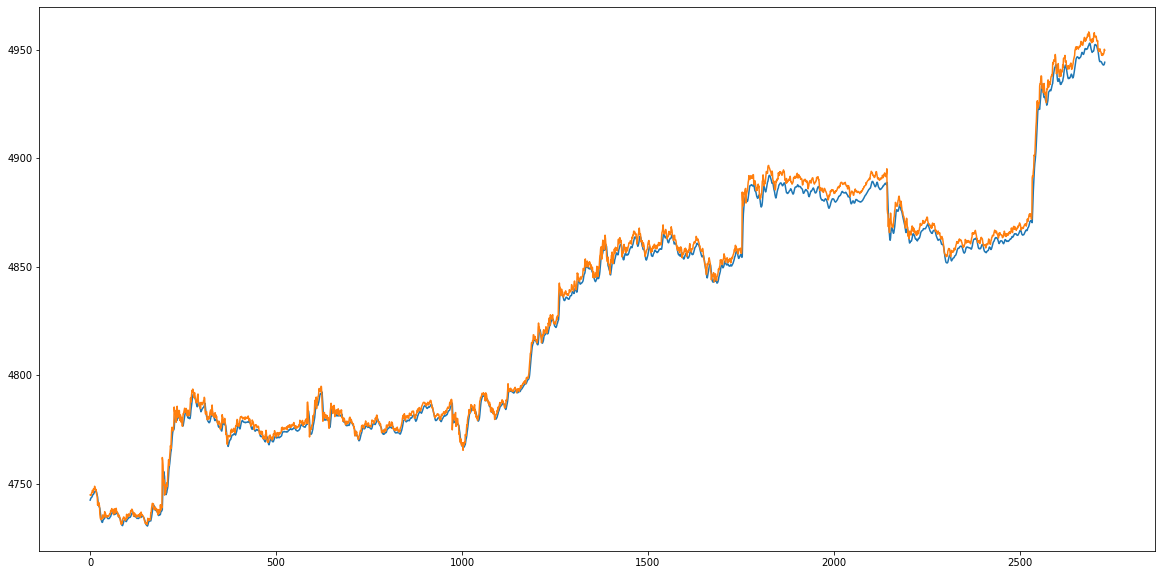

Iter:  11 train:  0.009325687531786328 val:  0.01146384559149867
Iter:  12 train:  0.009292258620431173 val:  0.015189287950697045
Iter:  13 train:  0.008816092719431316 val:  0.010083189356805083
Saving...
Iter:  14 train:  0.008717718111761738 val:  0.008434751570922687
Saving...
Iter:  15 train:  0.009115415182831654 val:  0.007716182424183196
Saving...
Iter:  16 train:  0.008550410322691987 val:  0.007509722473101475
Saving...
Iter:  17 train:  0.00831616381372097 val:  0.007343580233609765
Iter:  18 train:  0.008120740983403499 val:  0.007463720952360431
Iter:  19 train:  0.008191051659712281 val:  0.008649639330813223
Iter:  20 train:  0.007904466490690265 val:  0.00734888070038669
mse:  3.7170327 mae:  1.3163007


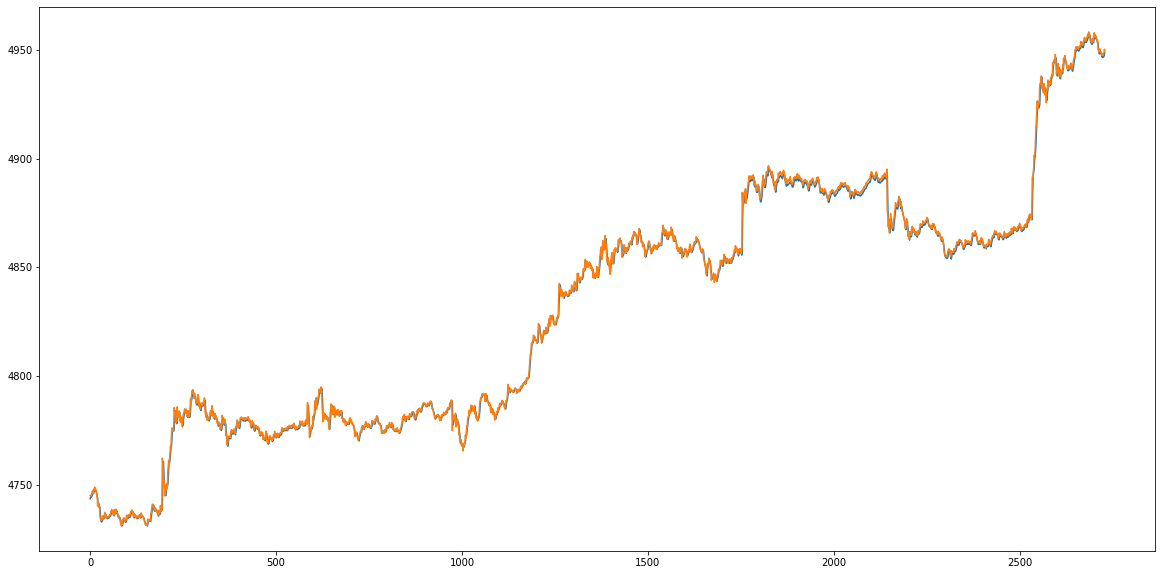

Saving...
Iter:  21 train:  0.007880676205232022 val:  0.007250940604448371
Saving...
Iter:  22 train:  0.007671924229378754 val:  0.006979784369905402
Iter:  23 train:  0.007531720845893486 val:  0.008948384027599657
Iter:  24 train:  0.007437565220059533 val:  0.007245499293029526
Saving...
Iter:  25 train:  0.007292050818964597 val:  0.006274979586661001
Iter:  26 train:  0.007104973353730204 val:  0.008700938479286683
Iter:  27 train:  0.0070507917436020305 val:  0.006576564019476591
Iter:  28 train:  0.007455287452295213 val:  0.012132788231294581
Iter:  29 train:  0.007237765964427274 val:  0.007390327316069453
Iter:  30 train:  0.006961837218428033 val:  0.006523053896838466
mse:  2.928565 mae:  1.1353551


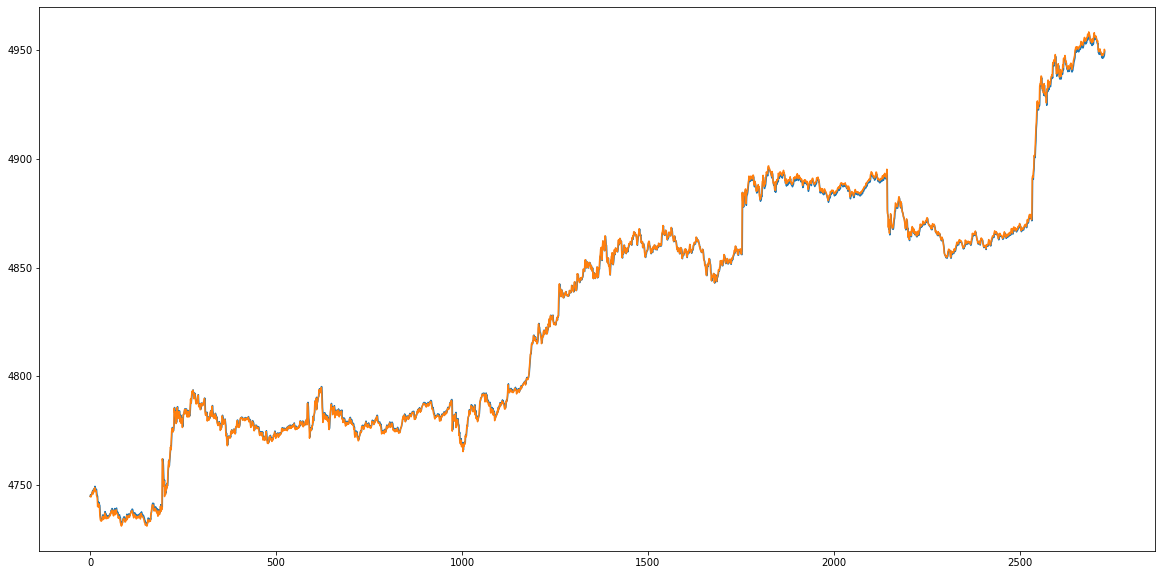

Iter:  31 train:  0.0069501309201035946 val:  0.006670516434915751
Saving...
Iter:  32 train:  0.007036510474153003 val:  0.006239183400532691
Iter:  33 train:  0.006937759309065621 val:  0.012967984588507762
Iter:  34 train:  0.007156751921528056 val:  0.010566873870374584
Iter:  35 train:  0.00692699843650432 val:  0.006333741355592353
Iter:  36 train:  0.00688559832147999 val:  0.0064953345194598165
Iter:  37 train:  0.007047357295298038 val:  0.006567613401146548
Iter:  38 train:  0.0068793281242949585 val:  0.006275004803173929
Iter:  39 train:  0.006874637940692158 val:  0.006252034721494165
Iter:  40 train:  0.006674311813086245 val:  0.006338608579997273
mse:  2.7652733 mae:  1.0626816


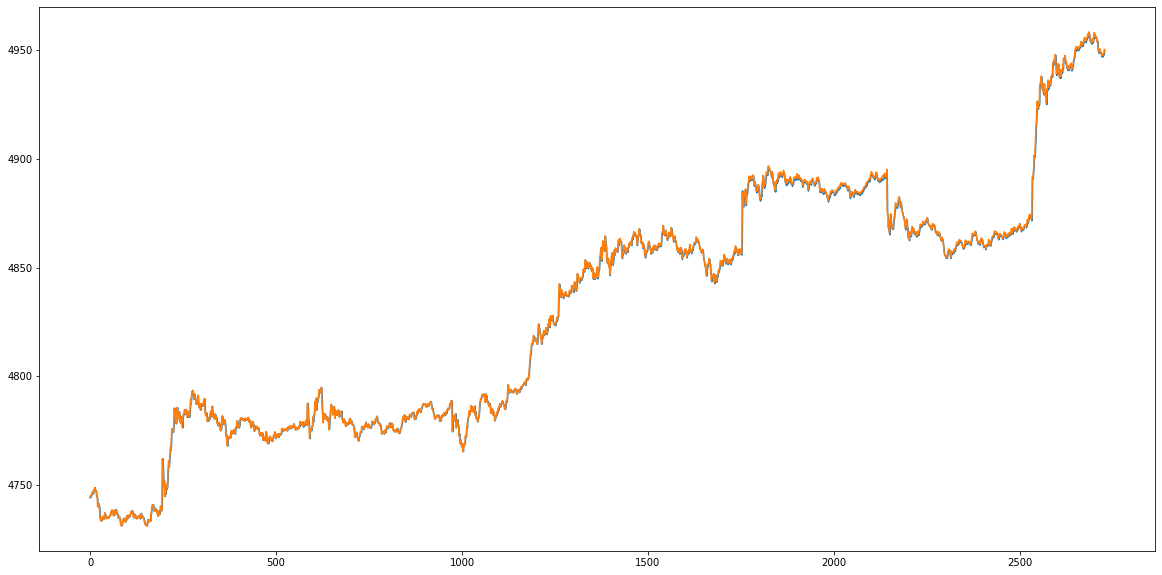

Iter:  41 train:  0.006799476926339976 val:  0.00649918268977829
Saving...
Iter:  42 train:  0.007041947469183054 val:  0.006237403653091152
Iter:  43 train:  0.007034206344661281 val:  0.006315305281436509
Iter:  44 train:  0.006970686502134745 val:  0.015712462805773767
Iter:  45 train:  0.006906305417273699 val:  0.007912098724931357
Iter:  46 train:  0.00686399510585406 val:  0.006247261921318041
Iter:  47 train:  0.006777961555489782 val:  0.007720171318603428
Saving...
Iter:  48 train:  0.006733927809775755 val:  0.0062155330364643754
Iter:  49 train:  0.006901015220419109 val:  0.0062592278691304196
Iter:  50 train:  0.006730223775406211 val:  0.006782250020353192
mse:  3.1659133 mae:  1.2287312


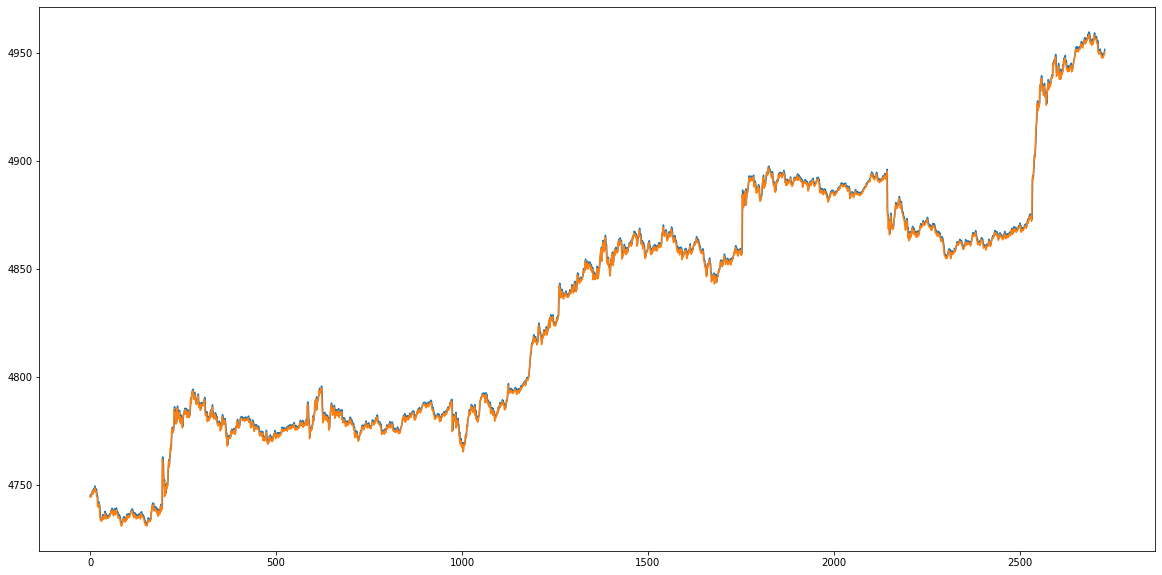

Iter:  51 train:  0.0069436771645399594 val:  0.007283213109601274
Iter:  52 train:  0.006789088105556785 val:  0.006220282830109107
Saving...
Iter:  53 train:  0.0067793014593458085 val:  0.006162828846768917
Iter:  54 train:  0.0067151336656999195 val:  0.008402231720205895
Iter:  55 train:  0.007058629847810685 val:  0.006453085318321117
Iter:  56 train:  0.0067737222966788545 val:  0.006410402421164997
Iter:  57 train:  0.006680304305663042 val:  0.006188901388987618
Iter:  58 train:  0.0067622850472877855 val:  0.006553168880161249
Iter:  59 train:  0.006712371529345133 val:  0.009525189538591126
Iter:  60 train:  0.00670826367356682 val:  0.00823628257515073
mse:  4.668907 mae:  1.6317204


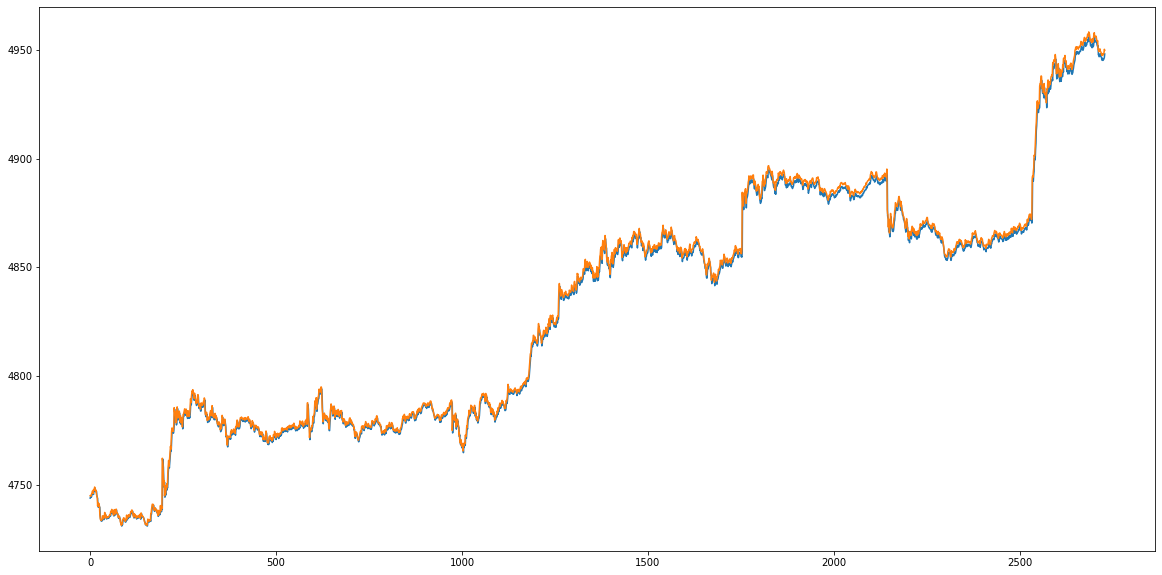

Iter:  61 train:  0.006805381159015118 val:  0.006658297455527384
Saving...
Iter:  62 train:  0.006755943760989859 val:  0.00615425398805825
Iter:  63 train:  0.006749025617410761 val:  0.007668730241969326
Iter:  64 train:  0.006755875103186751 val:  0.006636731433597721
Iter:  65 train:  0.006688025521311237 val:  0.006384038827913887
Iter:  66 train:  0.006654269058869471 val:  0.008731785411321226
Iter:  67 train:  0.006730704609892853 val:  0.006822586945447745
Iter:  68 train:  0.006733570367933917 val:  0.00623025379524855
Iter:  69 train:  0.006709818827833669 val:  0.007530851233441884
Iter:  70 train:  0.006752894418006256 val:  0.007626778974838561
mse:  4.0034375 mae:  1.4421208


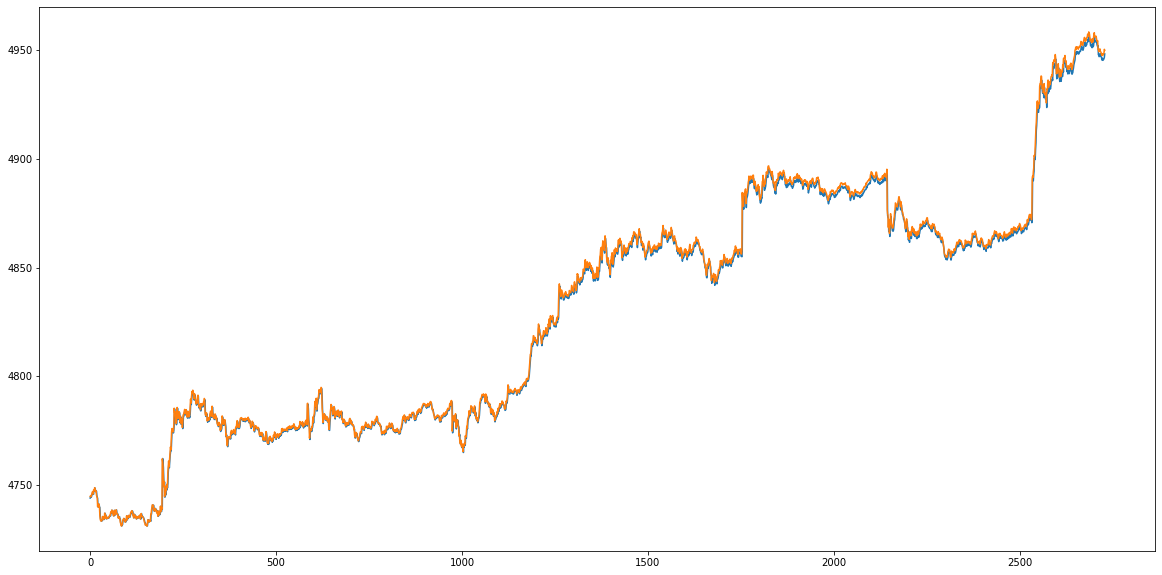

Iter:  71 train:  0.006779078795639665 val:  0.007316695287309359
Iter:  72 train:  0.006679248805176621 val:  0.0064382529547758974
Iter:  73 train:  0.006784061504967601 val:  0.008412999595631175
Iter:  74 train:  0.0067462833276355945 val:  0.006423758972086621
Iter:  75 train:  0.006797133564265785 val:  0.009512983313402626
Iter:  76 train:  0.006665070690992156 val:  0.007078634411956819


In [25]:
epochs = 150
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "darnn_nasdaq.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [26]:
model.load_state_dict(torch.load("darnn_nasdaq.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output = model(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

/home/demouser/good_python/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/demouser/good_python/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [28]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [29]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [30]:
mse, mae

(1.9975806, 0.90149224)

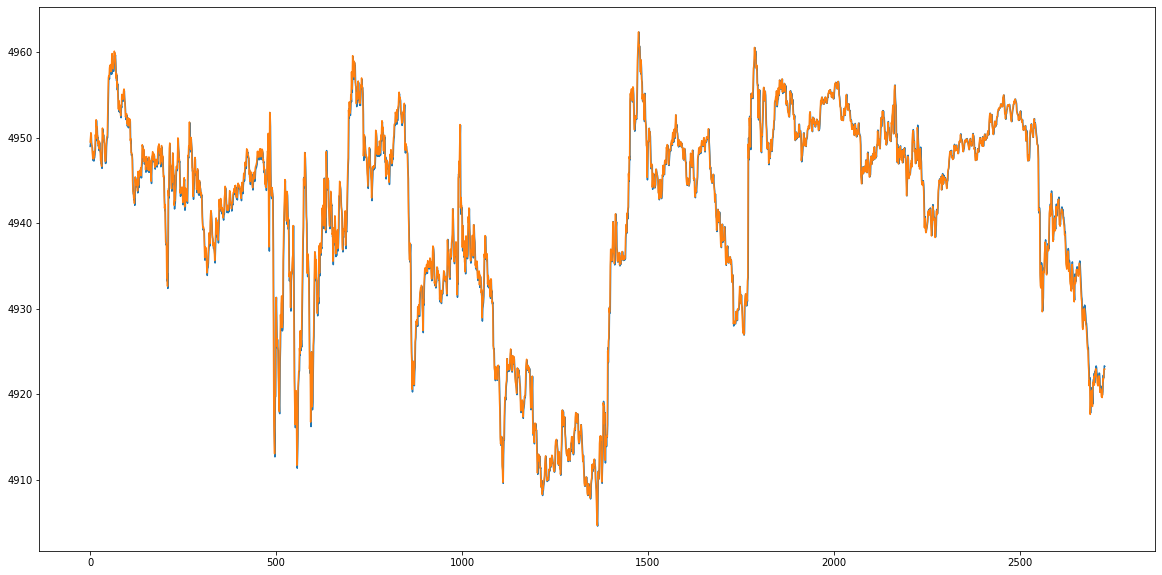

In [31]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()